In [1]:
%matplotlib inline
import os
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import torch
from hydra import compose, initialize
from omegaconf import OmegaConf

from datasets.imagenet import get_imagenet_dataset
from utils.degredations import H_functions

In [179]:
class Inpainting(H_functions):
    def __init__(self, channels, img_dim, dense_masks, device):
        self.channels = channels
        self.img_dim = img_dim
        self.dense_masks = dense_masks
        n = dense_masks.size(0)
        self.missing_masks = torch.cat([torch.nonzero(dense_masks[i] == 0).long() for i in range(n)], dim=1).T
        self.keep_masks = torch.cat([torch.nonzero(dense_masks[i] != 0).long() for i in range(n)], dim=1).T
        self.device = device
        
    def set_indices(self, idx):
        channels = self.channels
        img_dim = self.img_dim
        idx = torch.remainder(idx, self.missing_masks.size(0))
        print(idx)
        self.missing_indices = missing_indices = self.missing_masks[idx]
        device = self.device
        self._singulars = torch.ones(channels * img_dim ** 2 - missing_indices.shape[1]).to(device)
        self.kept_indices = self.keep_masks[idx]

    def V(self, vec):
        temp = vec.clone().reshape(vec.shape[0], -1)
        out = torch.zeros_like(temp)
        assert vec.size(0) == self.kept_indices.size(0)
        n = vec.size(0)
        for i in range(n):
            out[i, self.kept_indices[i]] = temp[i, : self.kept_indices[i].shape[0]]
            out[i, self.missing_indices[i]] = temp[i, self.kept_indices[i].shape[0] :]
        return out #.reshape(vec.shape[0], -1, self.channels).permute(0, 2, 1).reshape(vec.shape[0], -1)

    def Vt(self, vec):
        temp = vec.clone().reshape(vec.shape[0], -1)
        out = torch.zeros_like(temp)
        assert vec.size(0) == self.kept_indices.size(0)
        n = vec.size(0)
        for i in range(n):
            out[i, : self.kept_indices[i].shape[0]] = temp[i, self.kept_indices[i]]
            out[i, self.kept_indices[i].shape[0] :] = temp[i, self.missing_indices[i]]
        return out

    def U(self, vec):
        return vec.clone().reshape(vec.shape[0], -1)

    def Ut(self, vec):
        return vec.clone().reshape(vec.shape[0], -1)

    def singulars(self):
        return self._singulars

    def add_zeros(self, vec):
        temp = torch.zeros((vec.shape[0], self.channels * self.img_dim ** 2), device=vec.device)
        reshaped = vec.clone().reshape(vec.shape[0], -1)
        temp[:, : reshaped.shape[1]] = reshaped
        return temp

    def H(self, vec):
        """
        Multiplies the input vector by H
        """
        temp = self.Vt(vec)
        singulars = self.singulars()
        return self.U(singulars * temp[:, :singulars.shape[0]])

    def Ht(self, vec):
        """
        Multiplies the input vector by H transposed
        """
        temp = self.Ut(vec)
        singulars = self.singulars()
        return self.V(self.add_zeros(singulars * temp[:, : singulars.shape[0]]))

    def H_pinv(self, vec):
        """
        Multiplies the input vector by the pseudo inverse of H
        """
        temp = self.Ut(vec)  # (b, m) - > (b, m)
        singulars = self.singulars()  # (mxm, )
        # temp[:, :singulars.shape[0]] = temp[:, :singulars.shape[0]] / singulars
        nonzero_idx = singulars.nonzero().flatten()
        temp[:, nonzero_idx] = temp[:, nonzero_idx] / singulars[nonzero_idx]

        return self.V(self.add_zeros(temp))


# a memory inefficient implementation for any general degradation H

In [113]:
masks = torch.eye(9)[:4]
masks = torch.cat([torch.nonzero(masks[i] == 0).long() for i in range(4)], dim=1).T
hw = 9
masks = torch.cat([masks, masks+hw, masks+2*hw], dim=1)

img = torch.randn(2, 3, 3, 3)
inp = Inpainting(3, 3, masks, masks.device)
inp.set_indices(torch.tensor([0, 1]).long())

inp.H(img) #.view(2, 3, 3, 3)

tensor([[ 0.3976, -0.5797,  0.3712],
        [ 0.5644, -0.4165, -0.1824]])

In [112]:
ratio = 0.90
h, w = 256, 256
masks = torch.randperm(h * w)[: int((h * w)*0.90)].to(device).long() * 3

tensor([-0.0557,  0.8483, -1.9537])

In [92]:
inp.missing_indices

tensor([[1, 2, 3, 4, 5, 6, 7, 8],
        [0, 2, 3, 4, 5, 6, 7, 8]])

In [93]:
img = torch.randn(2, 1, 3, 3)

In [114]:
img

tensor([[[[ 0.3976, -0.1250, -1.1528],
          [ 1.0684, -0.5134, -1.3438],
          [ 0.7255,  0.8669, -0.6008]],

         [[-0.5797, -0.3250,  1.8960],
          [-0.4827,  0.2498,  1.2882],
          [ 0.2514,  1.1274,  0.7566]],

         [[ 0.3712,  0.6022, -1.1351],
          [-2.0729, -0.1747,  1.0337],
          [ 1.7886,  1.7362, -0.2050]]],


        [[[-1.2952,  0.5644,  0.6082],
          [-0.9351, -0.9494,  0.7845],
          [ 1.4788, -0.9498, -1.3445]],

         [[-0.5241, -0.4165,  0.7974],
          [ 0.2611,  0.6056,  0.1050],
          [-2.0107, -0.6487,  0.1147]],

         [[ 0.5575, -0.1824,  0.8770],
          [-0.0078,  1.3686,  1.5046],
          [ 0.2127, -0.8637, -0.1466]]]])

In [119]:
def random_sq_bbox(img, mask_shape, image_size=256, margin=(16, 16)):
    """Generate a random sqaure mask for inpainting
    """
    B, C, H, W = img.shape
    h, w = mask_shape
    margin_height, margin_width = margin
    maxt = image_size - margin_height - h
    maxl = image_size - margin_width - w

    # bb
    t = np.random.randint(margin_height, maxt)
    l = np.random.randint(margin_width, maxl)

    # make mask
    mask = torch.ones([B, C, H, W], device=img.device)
    mask[..., t:t+h, l:l+w] = 0

    return mask, t, t+h, l, l+w

In [ ]:
def random_mask(img, mask_shape, image_size=256, margin=(16, 16)):
    """Generate a random sqaure mask for inpainting
    """
    B, C, H, W = img.shape
    h, w = mask_shape
    margin_height, margin_width = margin
    maxt = image_size - margin_height - h
    maxl = image_size - margin_width - w

    # bb
    t = np.random.randint(margin_height, maxt)
    l = np.random.randint(margin_width, maxl)

    # make mask
    mask = torch.ones([B, C, H, W], device=img.device)
    mask[..., t:t+h, l:l+w] = 0

    return mask, t, t+h, l, l+w

In [240]:
img = torch.randn(1, 3, 256, 256)
mask = torch.cat([random_sq_bbox(img, [128, 128])[0].view(1, -1) for i in range(1000)], dim=0)

In [53]:
m = torch.diag(torch.arange(9))

m[torch.nonzero(m)[:, 0], torch.arange(5)]

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [8], [5]

In [127]:
mask.size()

torch.Size([1000, 65536])

In [157]:
masks = torch.cat([torch.nonzero(mask[i] == 0).long() for i in range(1000)], dim=1).T

In [153]:
masks.size()

torch.Size([1000, 16384])

In [246]:
inp = Inpainting(3, 256, torch.from_numpy(z), mask.device)

In [247]:

import imageio.v3 as iio
a = torch.from_numpy(iio.imread('adm.png')).permute(2, 0, 1).view(-1, 3, 256, 256).float() / 255

In [249]:
inp.set_indices(torch.tensor([900]).long())

tensor([900])


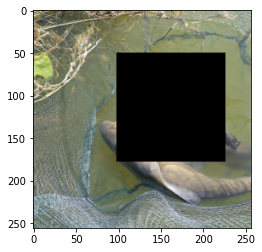

In [250]:
plt.imshow(inp.H_pinv(inp.H(a)).view(3, 256, 256).permute(1, 2, 0))

In [146]:
inp.H(a).size()

torch.Size([1, 147456])

In [161]:
torch.nonzero(mask[0] == 0).long().size()

torch.Size([49152, 1])

In [163]:
torch.remainder(torch.tensor([-3, -2, -1, 1, 2, 3]), 1)

tensor([0, 0, 0, 0, 0, 0])

In [173]:
mask.size()

torch.Size([1000, 196608])

In [195]:
mask.size()

torch.Size([1000, 196608])

In [216]:
np.save('extreme.npy', mask.cpu().numpy().astype(bool))

In [34]:
mask = np.ones([10, 3, 256, 256])
mask[:, :, 64:64+128, 64:64+128] = 0
mask = np.reshape(mask, [10, -1])

In [2]:
def save_mask(f, mask):
    m_npy = mask.astype(bool)
    m = np.packbits(m_npy, axis=None)
    shape = m_npy.shape
    np.savez(f, m=m, shape=shape)

In [3]:
def load_mask(f):
    d = np.load(f)
    m = d['m']
    shape = d['shape']
    m = np.unpackbits(m, count=np.prod(shape)).reshape(shape).view(bool)
    return m

In [244]:
save_mask('box.npz', mask.cpu().numpy())

In [28]:
z = load_mask('../_exp/masks/center.npz')

In [14]:
zz = np.random.rand(*z.shape) < 0.1

In [35]:
save_mask('../_exp/masks/center.npz', mask)

In [28]:
a = np.load('../_exp/fid_stats/imagenet256_val.npy').astype(np.float64)

In [18]:
zz = np.reshape(zz, [1000, 3, 256, 256])

ValueError: cannot reshape array of size 196608000 into shape (1000,256,256)

In [29]:
np.mean(z)

1.0

In [67]:
np.cov(a[:bs], rowvar=False) /np.cov(a[:bs], rowvar=False, ddof=0)

/tmp/ipykernel_919532/1174158367.py:1: RuntimeWarning: invalid value encountered in true_divide
  np.cov(a[:bs], rowvar=False) /np.cov(a[:bs], rowvar=False, ddof=0)


array([[1.00250627, 1.00250627, 1.00250627, ..., 1.00250627, 1.00250627,
        1.00250627],
       [1.00250627, 1.00250627, 1.00250627, ..., 1.00250627, 1.00250627,
        1.00250627],
       [1.00250627, 1.00250627, 1.00250627, ..., 1.00250627, 1.00250627,
        1.00250627],
       ...,
       [1.00250627, 1.00250627, 1.00250627, ..., 1.00250627, 1.00250627,
        1.00250627],
       [1.00250627, 1.00250627, 1.00250627, ..., 1.00250627, 1.00250627,
        1.00250627],
       [1.00250627, 1.00250627, 1.00250627, ..., 1.00250627, 1.00250627,
        1.00250627]])

In [7]:
b = a[:100]

In [36]:
0.0025 * 400

1.0

In [42]:
(np.cov(a[:100], rowvar=False, ddof=0) + np.mean(a[:100], axis=0, keepdims=True).T @ np.mean(a[:100], axis=0, keepdims=True) + np.cov(a[100:200], rowvar=False, ddof=0) + np.mean(a[100:200], axis=0, keepdims=True).T @ np.mean(a[100:200], axis=0, keepdims=True))/2 - np.mean(a[:200], axis=0, keepdims=True).T @ np.mean(a[:200], axis=0, keepdims=True)

array([[ 2.61952459e-02, -2.27256246e-05, -7.93342139e-04, ...,
         8.94077449e-03,  1.35471126e-04,  5.65158695e-04],
       [-2.27256246e-05,  3.87965974e-07,  3.60297245e-06, ...,
        -1.63149421e-05,  4.32674043e-07,  1.53936416e-06],
       [-7.93342139e-04,  3.60297245e-06,  5.19189382e-04, ...,
        -5.10112524e-04,  8.08954524e-05,  3.90613980e-05],
       ...,
       [ 8.94077449e-03, -1.63149421e-05, -5.10112524e-04, ...,
         1.05432384e-02,  2.29026487e-04,  8.43914228e-04],
       [ 1.35471126e-04,  4.32674043e-07,  8.08954524e-05, ...,
         2.29026487e-04,  3.33270942e-04,  1.65852001e-04],
       [ 5.65158695e-04,  1.53936416e-06,  3.90613980e-05, ...,
         8.43914228e-04,  1.65852001e-04,  1.52832223e-03]])

In [39]:

bs = 400

a1 = a[:bs].reshape(bs, 2048, 1)
a2 = a[:bs].reshape(bs, 1, 2048)

(np.mean(a1 @ a2, axis=0) - np.mean(a[:bs], axis=0, keepdims=True).T @ np.mean(a[:bs], axis=0, keepdims=True)) / (bs - 1) * bs

array([[ 2.87248221e-02, -2.79008390e-05, -4.97784028e-04, ...,
         9.43351527e-03, -2.15177407e-04,  5.95488769e-04],
       [-2.79008390e-05,  3.36359181e-06,  3.13609163e-06, ...,
        -3.91496588e-05,  1.98828306e-06, -4.74588886e-06],
       [-4.97784028e-04,  3.13609163e-06,  4.54202693e-04, ...,
        -1.11218249e-04,  8.58379521e-05,  3.32948429e-05],
       ...,
       [ 9.43351527e-03, -3.91496588e-05, -1.11218249e-04, ...,
         1.07787726e-02,  2.41690910e-04,  8.58987031e-04],
       [-2.15177407e-04,  1.98828306e-06,  8.58379521e-05, ...,
         2.41690910e-04,  5.97617082e-04,  1.18886984e-04],
       [ 5.95488769e-04, -4.74588886e-06,  3.32948429e-05, ...,
         8.58987031e-04,  1.18886984e-04,  1.43155485e-03]])

In [44]:
np.cov(a[:1000], rowvar=False, ddof=0)

array([[ 3.89639454e-02, -6.02294947e-05, -4.63518477e-04, ...,
         1.29903992e-02,  1.29509968e-05,  9.96997831e-05],
       [-6.02294947e-05,  3.34454146e-06,  2.99277148e-06, ...,
        -2.67707058e-05,  3.51079073e-07,  1.15651993e-06],
       [-4.63518477e-04,  2.99277148e-06,  5.69166303e-04, ...,
        -9.12235129e-05,  8.08716635e-05,  5.56085336e-05],
       ...,
       [ 1.29903992e-02, -2.67707058e-05, -9.12235129e-05, ...,
         1.49818428e-02,  3.27610795e-04,  1.27259149e-03],
       [ 1.29509968e-05,  3.51079073e-07,  8.08716635e-05, ...,
         3.27610795e-04,  4.82016916e-04,  2.03700784e-04],
       [ 9.96997831e-05,  1.15651993e-06,  5.56085336e-05, ...,
         1.27259149e-03,  2.03700784e-04,  2.01401598e-03]])

In [68]:
d = np.load('../_exp/fid_stats/debug_mean_std.npz')

In [69]:
d['sigma']

array([[ 4.19862400e-02, -1.19536319e-04,  2.00058838e-05, ...,
         1.22718443e-02,  6.67558222e-05, -6.19603251e-05],
       [-1.19536319e-04,  3.24843876e-05,  1.22161896e-05, ...,
        -1.13554018e-04, -6.28035315e-06, -4.40776572e-06],
       [ 2.00058838e-05,  1.22161896e-05,  5.13983041e-04, ...,
         9.15496096e-05,  6.61750516e-05,  9.91142476e-05],
       ...,
       [ 1.22718443e-02, -1.13554018e-04,  9.15496096e-05, ...,
         1.82307286e-02,  1.13482541e-04,  2.10300837e-03],
       [ 6.67558222e-05, -6.28035315e-06,  6.61750516e-05, ...,
         1.13482541e-04,  6.17686438e-04,  1.13561884e-04],
       [-6.19603251e-05, -4.40776572e-06,  9.91142476e-05, ...,
         2.10300837e-03,  1.13561884e-04,  2.55475175e-03]])

In [59]:
e = np.load('../_exp/fid_stats/debug.npy').astype(np.float64)

In [60]:
np.cov(e, rowvar=False)

array([[ 4.19862400e-02, -1.19536319e-04,  2.00058838e-05, ...,
         1.22718443e-02,  6.67558222e-05, -6.19603251e-05],
       [-1.19536319e-04,  3.24843876e-05,  1.22161896e-05, ...,
        -1.13554018e-04, -6.28035315e-06, -4.40776572e-06],
       [ 2.00058838e-05,  1.22161896e-05,  5.13983041e-04, ...,
         9.15496096e-05,  6.61750516e-05,  9.91142476e-05],
       ...,
       [ 1.22718443e-02, -1.13554018e-04,  9.15496096e-05, ...,
         1.82307286e-02,  1.13482541e-04,  2.10300837e-03],
       [ 6.67558222e-05, -6.28035315e-06,  6.61750516e-05, ...,
         1.13482541e-04,  6.17686438e-04,  1.13561884e-04],
       [-6.19603251e-05, -4.40776572e-06,  9.91142476e-05, ...,
         2.10300837e-03,  1.13561884e-04,  2.55475175e-03]])

In [52]:
e.shape

(1000, 2048)

In [61]:
pbar = [e[:200], e[200:400], e[400:600], e[600:800], e[800:]]

moment1 = None
moment2 = None
size = 0
for features in pbar:
    if moment1 is None:
        moment1 = np.mean(features, axis=0)
        moment2 = np.cov(features, rowvar=False, ddof=0) + (moment1.reshape([-1, 1]) @ moment1.reshape([1, -1]))
    else:
        m1 = np.mean(features, axis=0)
        m2 = np.cov(features, rowvar=False, ddof=0) + (m1.reshape([-1, 1]) @ m1.reshape([1, -1]))
        moment1 = (moment1 * size + m1 * features.shape[0]) / (size + features.shape[0])
        moment2 = (moment2 * size + m2 * features.shape[0]) / (size + features.shape[0])
    size = size + features.shape[0]

In [66]:
(moment2 - moment1.reshape([-1, 1]) @ moment1.reshape([1, -1])) * size / (size - 1)

array([[ 4.19862400e-02, -1.19536319e-04,  2.00058838e-05, ...,
         1.22718443e-02,  6.67558222e-05, -6.19603251e-05],
       [-1.19536319e-04,  3.24843876e-05,  1.22161896e-05, ...,
        -1.13554018e-04, -6.28035315e-06, -4.40776572e-06],
       [ 2.00058838e-05,  1.22161896e-05,  5.13983041e-04, ...,
         9.15496096e-05,  6.61750516e-05,  9.91142476e-05],
       ...,
       [ 1.22718443e-02, -1.13554018e-04,  9.15496096e-05, ...,
         1.82307286e-02,  1.13482541e-04,  2.10300837e-03],
       [ 6.67558222e-05, -6.28035315e-06,  6.61750516e-05, ...,
         1.13482541e-04,  6.17686438e-04,  1.13561884e-04],
       [-6.19603251e-05, -4.40776572e-06,  9.91142476e-05, ...,
         2.10300837e-03,  1.13561884e-04,  2.55475175e-03]])

In [63]:
np.mean(e, axis=0)

array([8.82224473e-01, 6.93745786e-04, 4.92905265e-02, ...,
       3.50172087e-01, 3.00581385e-02, 9.83726549e-02])